### Description

__Describe what was mentioned in the proposal.__

 - Significance test between the number of shared reactants and products a reaction has and the essentiality. The two groups are repressented by essentiality while the amount of shared products are presented by counting methods.

### Setup

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [51]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pd.set_option('display.width', 1000)
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tqdm
import cobra
from cobra.io import read_sbml_model
from pathlib import Path
from collections import Counter
import os
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from scipy.stats import spearmanr
from sklearn import preprocessing
import scipy.optimize
from scipy.stats import pearsonr, spearmanr
from scipy.stats import chi2_contingency, fisher_exact, mannwhitneyu, median_test, chisquare
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Functions

#### Centrality functions

In [61]:
def get_betweenness_centrality_log10(model_graph_df):
    
    # calculate betweenness centrality
    model_betweenness_centrality = nx.betweenness_centrality(model_graph_df, weight='weight', normalized=False)
    
    # strip whitespace from keys and log-transform the values
    log10_betweenness_centrality = {key.strip(): np.log10(value + 1) for key, value in model_betweenness_centrality.items()}
    return log10_betweenness_centrality

def get_bridging_centrality_log10(model_graph_df):
    
    # calculate betweenness centrality
    betweenness = nx.betweenness_centrality(model_graph_df, weight='weight', normalized=False)

    # calculate the bridging coefficient for each node
    bridging_coefficient = {}
    for node in model_graph_df.nodes():
        # for directed graphs, consider successors and predecessors
        if model_graph_df.is_directed():
            successors = list(model_graph_df.successors(node))
            predecessors = list(model_graph_df.predecessors(node))
            degree_sum = sum(model_graph_df.out_degree(successor) for successor in successors) + \
                         sum(model_graph_df.in_degree(predecessor) for predecessor in predecessors)
        else:
            # for undirected graphs, consider neighbors
            neighbors = list(model_graph_df.neighbors(node))
            degree_sum = sum(model_graph_df.degree(neighbor) for neighbor in neighbors)

        bridging_coefficient[node] = 1 / degree_sum if degree_sum > 0 else 0

    # calculate bridging centrality
    bridging_centrality = {node: betweenness[node] * bridging_coefficient[node] for node in model_graph_df.nodes()}

    # strip whitespace from keys and log-transform the values
    log10_bridging_centrality = {key.strip(): np.log10(value + 1) for key, value in bridging_centrality.items()}
    return log10_bridging_centrality

def get_clustering_coefficient(model_graph_df):
    model_clustering_coefficient = nx.clustering(model_graph_df)

    # strip whitespace from keys and log-transform the values
    clustering_coefficient = {key.strip(): value for key, value in model_clustering_coefficient.items()}
    return clustering_coefficient

def get_degree(model_graph_df, log=False, directional=False):
    model_degree = dict(model_graph_df.degree())
    model_degree = {key.strip(): value for key, value in model_degree.items()}
    
    if (directional):
        c=0
    
    # strip whitespace from keys and log-transform the values
    if (log):
        model_degree = {key.strip(): np.log10(value + 1) for key, value in model_degree.items()}
    return model_degree

#### Processing functions

In [62]:
def dict_isolate(dic, val):
    match_keys=[]
    for key, value in dic.items():
        if (value==val):
            match_keys.append(key)
    return match_keys

def df_isolate(df, col, val):
    return df[df[col]==val]

def log_columns(df, cols, base=2):
    for col in cols:
        if (base==2):
            df[f"log_{col}"]=np.log(df[col]+1)
        elif (base==10):
            df[f"log_{col}"]=np.log10(df[col]+1)
        else:
            print("Choose valid base (2 or 10)")
    return df

def normalize(data, lower, upper):
    data_norm=[lower + (upper - lower) * x for x in data]
    return data_norm

def adj_columns(df, cols, prefix):
    for col in cols:
        d=np.array(df[col])
        df[f"{prefix}_{col}"]=preprocessing.normalize([d]).tolist()[0]
    return df

def z_score(df, cols, prefix):
    for col in cols:
        d=np.array(df[col])
        df[f"{prefix}_{col}"]=stats.zscore(d).tolist()
    return df

def scale(df, cols, lb=0, ub=1):
    for col in cols:
        df[f"scale_{col}"]=scale_list(list(df[col]), lb, ub)
    return df

def scale_number(unscaled, to_min, to_max, from_min, from_max):
    return (to_max-to_min)*(unscaled-from_min)/(from_max-from_min)+to_min

def scale_list(l, to_min, to_max):
    return [scale_number(i, to_min, to_max, min(l), max(l)) for i in l]

def replace_index(df, replace_pairs):
    for r1, r2 in replace_pairs:
        df.index=df.index.str.replace(r1,r2)
    return df

def replace_column(df, replace_pairs):
    for r1, r2 in replace_pairs:
        df.columns=df.columns.str.replace(r1,r2)
    return df

def sort_dict(d):
    return {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}

def sorted_counter(data):
    return sort_dict(Counter(data))

def sharing_data_processing(data_df, base=2):
    # format
    data_df=pd.DataFrame.from_dict(data_df).T
    # data_df.columns=["r", "p", "num_r", "num_p", "ess"]
    data_df.columns=["r", "p", "num_r", "num_p", "rev", "r_all", "p_all", "p_push", "ess"]
    # data_df.columns=["ess", "r", "p"] # change column order based on above

    # merge
    data_df=pd.concat([data_df, cent_metrics_df], axis=1) # was degree_df
    
    # modify columns 
    mod_cols=["r", "p", "k_in", "k_out", "k", "r_all", "p_all", "p_push"]
    data_df[mod_cols]=data_df[mod_cols].astype(float)

    # log
    data_df=log_columns(data_df, mod_cols, base=base)

    # norm
    data_df=adj_columns(data_df, mod_cols, "norm")

    # norm
    data_df=z_score(data_df, mod_cols, "z")

    # scale
    data_df=scale(data_df, mod_cols)
    
    # reaction degree
    data_df_sources=data_df.loc[sources.index]
    data_df_sinks=data_df.loc[sinks.index]
    
    # reaction essentiality
    data_df_ess=data_df[data_df["ess"]==1]
    data_df_noness=data_df[data_df["ess"]==0]
    
    data_df=data_df.sort_values(by="r", ascending=False)
    
#     data_df["log_p_push_k_out"]=data_df["log_p_push"]/data_df["log_k_out"]

    return data_df, data_df_sources, data_df_sinks, data_df_ess, data_df_noness

def sharing_data_processing_2(data_df, data_df_sources, data_df_sinks, rm_sources=True, rm_sinks=True, base=2):

    # remove source and sink nodes
    if (rm_sources):
        data_df_f=data_df.drop(data_df_sources.index)
    else:
        data_df_f=data_df.copy()
        
    if (rm_sinks):
        data_df_f=data_df_f.drop(data_df_sinks.index)
        
    data_df_f["pp_kout"]=data_df_f["p_push"]/data_df_f["k_out"]
    data_df_f=log_columns(data_df_f, ["pp_kout"], base=base)

    # get ess and non ess 
    data_df_f_ess=data_df_f[data_df_f["ess"]==1]
    data_df_f_noness=data_df_f[data_df_f["ess"]==0]
    
    return data_df_f, data_df_f_ess, data_df_f_noness

#### Product sharing functions

In [63]:
# counts reactant and product sharing across all reactions
def all_prods_reacts_dict(fba_ecoli_lofo, ecoli_model, rev=False):
    
    all_reactants=[]
    all_products=[]
    for rxn in list(fba_ecoli_lofo.keys()):
        rxn_df=ecoli_model.reactions.get_by_id(rxn)
        rxn_reactants=rxn_df.reactants
        rxn_products=rxn_df.products
        rxn_reactants=[i.id for i in rxn_reactants]
        rxn_products=[i.id for i in rxn_products]

        rxn_reversibility=rxn_df.reversibility
        if (rev):
            if (rxn_reversibility):
                all_mets=rxn_reactants+rxn_products
                all_reactants+=all_mets
                all_products+=all_mets
            else:
                all_reactants+=rxn_reactants
                all_products+=rxn_products
        else:
            all_reactants+=rxn_reactants
            all_products+=rxn_products
        
    # count and convert to dictionary
    all_products_dict=Counter(all_products)
    all_reactants_dict=Counter(all_reactants)

    # sort dictionaries and create a list of metabolites to ignore because they are too prevelant
    all_products_dict={k: v for k, v in sorted(all_products_dict.items(), key=lambda item: item[1])}
    all_reactants_dict={k: v for k, v in sorted(all_reactants_dict.items(), key=lambda item: item[1])}
        
    return all_reactants_dict, all_products_dict

# create dataframe info in one dict
def split_react_prod_dict_by_ess(fba_ecoli_lofo):
    all_reactants_ess=[]
    all_products_ess=[]
    all_reactants_noness=[]
    all_products_noness=[]

    for rxn, obj in zip(fba_ecoli_lofo.keys(), fba_ecoli_lofo.values()):
        rxn_df=ecoli_model.reactions.get_by_id(rxn)
        rxn_reactants=rxn_df.reactants
        rxn_products=rxn_df.products
        rxn_reactants=[i.id for i in rxn_reactants]
        rxn_products=[i.id for i in rxn_products]
        if (obj < 2):
            all_reactants_ess+=rxn_reactants
            all_products_ess+=rxn_products
        else:
            all_reactants_noness+=rxn_reactants
            all_products_noness+=rxn_products

    # create dicts
    all_reactants_ess_dict=dict(Counter(all_reactants_ess))
    all_products_ess_dict=dict(Counter(all_products_ess))
    all_reactants_noness_dict=dict(Counter(all_reactants_noness))
    all_products_noness_dict=dict(Counter(all_products_noness))
    
    return all_reactants_ess_dict, all_products_ess_dict, all_reactants_noness_dict, all_products_noness_dict

#### Product push testing functions

In [64]:
# product push functions
def get_reaction_information(rxn, model):
    rxn_df=model.reactions.get_by_id(rxn)
    reversibility=rxn_df.reversibility
    rxn_reactants, rxn_products=rxn_df.reactants, rxn_df.products
    rxn_reactant_names=[i.id for i in rxn_reactants]
    rxn_product_names=[i.id for i in rxn_products]
    all_metabolites=rxn_reactants+rxn_products
    all_metabolite_names=rxn_reactant_names+rxn_product_names
    rxn_object={'df':rxn_df, 'rev':reversibility, 'r':rxn_reactants, 'p':rxn_products, 'rn': rxn_reactant_names, 'pn':rxn_product_names, 'm':all_metabolites, 'mn':all_metabolite_names}
    return rxn_object

# conducts product push for all mets in a reaction (based on reversibility)
def f1_product_push(rxn, model, graph, f1_rev=False, f2_rev=False):
    rxn_object=get_reaction_information(rxn, model)
    reversibility=rxn_object['rev']
    mets=rxn_object['pn']
    if (f1_rev and reversibility):
        mets=rxn_object['mn']
    rxn_neighbors=[n for n in graph.neighbors(rxn)]
    rxn_p_push={}
    for m in mets:
        p_push=[]
        for nxt_rxn in rxn_neighbors:
            p_push.append(f2_product_push(m, nxt_rxn, model, f2_rev=f2_rev))
        rxn_p_push[m]=sum(p_push)
    return rxn_p_push
        
# check how many times the given product appears in the next reaction
def f2_product_push(p, rxn, model, f2_rev=False):
    rxn_object=get_reaction_information(rxn, model)
    reversibility=rxn_object['rev']
    mets=rxn_object['rn']
    if (f2_rev and reversibility):
        mets=rxn_object['mn']
    p_push=sum([1 if (m==p) else 0 for m in mets])
    return p_push

def product_push_main(lofo_dict, model, graph, func, mets_to_ignore=[], f1_rev=False, f2_rev=False, ignore_zero_push=False, return_func_df=False):
    product_push_data={}
    product_push_func={}
    for rxn, obj in lofo_dict.items():
        rxn_p_push=f1_product_push(rxn, model, graph, f1_rev=f1_rev, f2_rev=f2_rev)
        if (len(mets_to_ignore)!=0 and len(rxn_p_push)!=0):
                rxn_p_push={key: value for key, value in rxn_p_push.items() if key not in mets_to_ignore}
        if (ignore_zero_push and len(rxn_p_push)!=0):
            rxn_p_push={key: value for key, value in rxn_p_push.items() if value!=0}
        if (len(rxn_p_push)==0):
            rxn_p_push_func=0
        else:
            rxn_p_push_func=func(list(rxn_p_push.values()))
        
        product_push_data[rxn]=rxn_p_push
        product_push_func[rxn]=rxn_p_push_func
        
    if (return_func_df):
        product_push_func=pd.DataFrame.from_dict(product_push_func, orient='index')
        product_push_func.columns=["p_push"]

    return product_push_data, product_push_func

# testing function
# product_push_data, product_push_func=product_push_main(fba_ecoli_lofo, ecoli_model, ecoli_dg, np.mean, mets_to_ignore=[], f1_rev=True, f2_rev=True, ignore_zero_push=True, return_func_df=True)

#### Aggregate product sharing and product push functions

In [65]:
# product sharing functions
def product_sharing(lofo_dict, graph, all_reactants_dict, all_products_dict, mets_to_ignore=[], s_func=min, pp_func=sum, return_pushin_p=False, ignore_zero_sharing=False):
    data={}
    num_reactants=[]
    num_products=[]
    pushin_p={}
    product_push_data, product_push_func=product_push_main(fba_ecoli_lofo, ecoli_model, ecoli_dg, pp_func, mets_to_ignore=mets_to_ignore, f1_rev=rev1, f2_rev=rev2, ignore_zero_push=ignore_zero_push, return_func_df=False)
    pushin_p=product_push_data
    for rxn, obj in zip(fba_ecoli_lofo.keys(), fba_ecoli_lofo.values()):
        loop_data=[]
        rxn_df=ecoli_model.reactions.get_by_id(rxn)
        reversibility=rxn_df.reversibility
        rxn_reactants=rxn_df.reactants
        rxn_products=rxn_df.products
        rxn_reactant_names=[i.id for i in rxn_reactants]
        rxn_product_names=[i.id for i in rxn_products]

        # get num reactants and products for each reaction
        num_reactants.append(len(rxn_reactant_names))
        num_products.append(len(rxn_product_names))

        # should be using all reactants or products
        r_sharing=[]
        p_sharing=[]
        for r in rxn_reactant_names:
            r_sharing.append(all_reactants_dict[r])

        for p in rxn_product_names:
            p_sharing.append(all_products_dict[p]) 

        # take function
        loop_data.append(func(r_sharing)) # min, max, or sum
        loop_data.append(func(p_sharing)) # min, max, or sum

        # append len of each
        loop_data.append(len(r_sharing))
        loop_data.append(len(p_sharing))

        # append reversibility
        loop_data.append(reversibility)

        # taking len() function as a metric for reaction sharing - from bigg database
        r_sharing=[len(i.reactions) for i in rxn_reactants]
        p_sharing=[len(i.reactions) for i in rxn_products]
        loop_data.append(func(r_sharing)) # min, max, or sum
        loop_data.append(func(p_sharing)) # min, max, or sum
        

        if (obj < 2):
            loop_data.append(1)
        else:
            loop_data.append(0)

        # add final data
        data[rxn]=loop_data
        
    if (return_pushin_p):
        return data, pushin_p
    return data 

# main product push and product sharing function
def get_sharing_data(fba_ecoli_lofo, ecoli_dg, all_reactants_dict, all_products_dict, mets_to_ignore, func=min, pp_func=sum, ignore_mets=True, rev1=True, rev2=True, return_pushin_p=False, ignore_zero_push=False):
    data={}
    num_reactants=[]
    num_products=[]
    pushin_p={}
    for rxn, obj in zip(fba_ecoli_lofo.keys(), fba_ecoli_lofo.values()):
        loop_data=[]
        rxn_df=ecoli_model.reactions.get_by_id(rxn)
        reversibility=rxn_df.reversibility
        rxn_reactants=rxn_df.reactants
        rxn_products=rxn_df.products
        rxn_reactant_names=[i.id for i in rxn_reactants]
        rxn_product_names=[i.id for i in rxn_products]

        # get num reactants and products for each reaction
        num_reactants.append(len(rxn_reactant_names))
        num_products.append(len(rxn_product_names))

        # should be using all reactants or products 
        r_sharing=[]
        p_sharing=[]
        for r in rxn_reactant_names:
            r_sharing.append(all_reactants_dict[r])

        for p in rxn_product_names:
            p_sharing.append(all_products_dict[p]) 

        # take function
        loop_data.append(func(r_sharing)) # min, max, or sum
        loop_data.append(func(p_sharing)) # min, max, or sum

        # append len of each
        loop_data.append(len(r_sharing))
        loop_data.append(len(p_sharing))

        # append reversibility
        loop_data.append(reversibility)

        # taking len() function as a metric for sharing - from bigg database
        r_sharing=[len(i.reactions) for i in rxn_reactants]
        p_sharing=[len(i.reactions) for i in rxn_products]
        loop_data.append(func(r_sharing)) # min, max, or sum
        loop_data.append(func(p_sharing)) # min, max, or sum
        
        ##### START PRODUCT PUSH CODE
        # see how products of selected rxn are used as reactants in next rxn
        node_out_neighbors=[n for n in ecoli_dg.neighbors(rxn)]
        product_pass_dict={}
        nxt_react=[]

        if (rev1):
            if (reversibility): # if the reaction is reversible, use both the products and the reactants to feed into the next reaction
                mets_to_consider=rxn_product_names+rxn_reactant_names
            else:
                mets_to_consider=rxn_product_names
        else:
            mets_to_consider=rxn_product_names

        for p in mets_to_consider:
            p_share_count=0
            for next_rxn in node_out_neighbors:
                next_rxn_df=ecoli_model.reactions.get_by_id(next_rxn)
                next_reversibility=next_rxn_df.reversibility
                next_rxn_reactants=next_rxn_df.reactants
                next_rxn_products=next_rxn_df.products
                next_rxn_reactant_names=[i.id for i in next_rxn_reactants]
                next_rxn_product_names=[i.id for i in next_rxn_products]
                nxt_react+=next_rxn_product_names
                if (len(nxt_react)==0):
                    print('no next products')

                # second reversibility clause
                if (rev2):
                    if (next_reversibility):
                        next_mets_to_consider=next_rxn_reactant_names+next_rxn_product_names
                    else:
                        next_mets_to_consider=next_rxn_reactant_names
                else:
                    next_mets_to_consider=next_rxn_reactant_names

                if (ignore_mets):
                    if p in mets_to_ignore.keys():
                        continue
                        
                if p in next_mets_to_consider:
                    p_share_count+=1

            # ignore zero product push if option selected
            if (ignore_zero_push):
                if (p_share_count==0):
                    continue
                else:
                    product_pass_dict[p]=p_share_count
            else:
                product_pass_dict[p]=p_share_count

        pushin_p[rxn]=product_pass_dict
        
        # get total product push forward
        product_push=pp_func(list(product_pass_dict.values())) # min, max, or sum
        ##### END PRODUCT PUSH CODE
                
        # append
        loop_data.append(product_push)

        if (obj < 2):
            loop_data.append(1)
        else:
            loop_data.append(0)


        # add final data
        data[rxn]=loop_data
        
    if (return_pushin_p):
        return data, pushin_p
    return data 

#### Regression fitting and plotting functions

In [120]:
def sk_lr(df, x_label, y_label):
    x=np.array(df[x_label]).reshape((-1, 1))
    y=np.array(df[y_label])
    model = LinearRegression()
    model.fit(x, y.reshape((-1, 1)))
    r_sq=model.score(x, y)
    print(f"coefficient of determination: {r_sq}")
    return r_sq
    
def sp_lr(df, x_label, y_label):
    x=np.array(df[x_label]) # .reshape((-1, 1))
    y=np.array(df[y_label])
    slope, intercept, r_value, p_value, std_err = linregress(y, x)
    print("Slope: ", slope)
    print("Intercept: ", intercept)
    print("r-value: ", r_value)
    print("p-value: ", p_value)
    print("standard error: ", std_err)
    return slope, intercept, r_value, p_value, std_err

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color='red')
    
def best_fit(X, Y):
    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)
    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2
    b = numer / denum
    a = ybar - b * xbar
    return a, b

def parabola(x, a, b, c):
    return a*x**2 + b*x + c


#### Histogram plotting functions

In [183]:
# assign bins for histogram
def assign_bins(df, col, bins, manual_bins=[], remove_outliers=False, q=0.99, z_filter=False, z_t=2, z_col='z_r', return_hist=False):
    
    # not used: remove outliers (https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe)
    if (remove_outliers):
        q = df[col].quantile(q)
        df=df[df[col] < q]

    if (z_filter):
        df=df[df[z_col]<z_t]
        
    col_data=list(df[col])
    
    # make sure min of data is not zero
    if (min(col_data)==0):
        print("Warning, minimum of data is zero.")
        
    if (len(manual_bins)==0):
        hist,bin_edges=np.histogram(col_data, bins=bins)
    else:
        hist,bin_edges=np.histogram(col_data, bins=manual_bins)
        
    hist=list(hist)
    bin_edges=list(bin_edges)
    
    # get bin edge pairs
    bin_edge_pairs={}
    for i in range(len(bin_edges)):
        if (i>=len(bin_edges)-1):
            break
        pair=(bin_edges[i], bin_edges[i+1])
        bin_edge_pairs[pair]=f"g{i}"        
        
    # bound the data
    df_hist=pd.DataFrame()
    for bin_pair, label in zip(bin_edge_pairs.keys(), bin_edge_pairs.values()):
        df_bounded=df.loc[df[col].between(bin_pair[0], bin_pair[1])]
        df_bounded["hist_label"]=label
        df_hist=pd.concat([df_hist, df_bounded])
        
    if (return_hist):
        return df_hist, hist, bin_edges, bin_edge_pairs
    else:
        return df_hist
    
# computes fraction of essential reactions
def compute_fraction_essential_hist(df_hist, hist, bin_edges, bin_edge_pairs, compute_ratio=False):
    df_ess=pd.DataFrame()
    df_ess["hist_label"]=list(bin_edge_pairs.values())
    df_ess["hist_counts"]=hist
    ess_counts=[]
    noness_counts=[]
    ess_fracs=[]
    bin_centers=[]
    left_bin=[]
    right_bin=[]
    for pair, label in zip(bin_edge_pairs.keys(), bin_edge_pairs.values()):
        bin_centers.append(np.mean(pair))
        left_bin.append(pair[0])
        right_bin.append(pair[1])
        df_hist_label=df_hist[df_hist["hist_label"]==label]
        num_ess=len(df_hist_label[df_hist_label["ess"]==1])
        num_noness=len(df_hist_label[df_hist_label["ess"]==0])
        if (compute_ratio):
            if (num_noness==0):
                frac_ess=0
            else:
                frac_ess=num_ess/num_noness
        else:
            if ((num_ess+num_noness)==0):
                frac_ess=0
            else:
                frac_ess=num_ess/(num_ess+num_noness)
        
        # append data
        ess_counts.append(num_ess)
        noness_counts.append(num_noness)
        ess_fracs.append(frac_ess)
        
    # update df
    df_ess["num_ess"]=ess_counts
    df_ess["num_noness"]=noness_counts
    df_ess["frac_ess"]=ess_fracs
    df_ess["left_bin"]=left_bin
    df_ess["bin_centers"]=bin_centers
    df_ess["right_bin"]=right_bin
    
    # return 
    return df_ess

def create_bins(lb, ub, s, mb=1):
    if (mb==1):
        manual_bins=list(np.arange(lb, ub, s))
        print(list(np.arange(lb, ub, s)))
        print(len(list(np.arange(lb, ub, s))))
    else: 
        manual_bins=[]
    return manual_bins

# plot histogram 
def plot_histogram(data_df_hist, data_df_ess_frac, xl, yl, subset=[], frac_ess=True):
    if (len(subset)!=0):
        data_df_hist=data_df_hist[data_df_hist["hist_label"].isin(subset)]
        data_df_ess_frac=data_df_ess_frac[data_df_ess_frac["hist_label"].isin(subset)]
    if (frac_ess):
        df_to_use=data_df_ess_frac.copy()
    else:
        df_to_use=data_df_hist.copy()
    x=df_to_use[xl]
    y=df_to_use[yl]
    sk_lr(df_to_use, xl, yl)
    plt.scatter(x, y)  
    plt.xlabel(xl)
    plt.ylabel(yl)
#     plt.show()
    
def group_ranges(b1, b2):
    subset=[]
    for i in range(b1,b2+1):
        subset.append(f"g{str(i)}")
    return subset

### Testing

#### Base LOFO analysis

In [8]:
# get graph
File_name = '12859_2019_2897_MOESM2_ESM.xlsx'

sheet_names = pd.ExcelFile(File_name).sheet_names
sheets = {}
for sheet in sheet_names:
    sheets[sheet] = pd.read_excel(File_name,sheet_name=sheet,index_col=0)
    
# load the graphs into a dictionary - only done for ecoli
graphs = {}
graphs[sheet_names[0]] = nx.from_pandas_adjacency(sheets[sheet_names[0]],create_using=nx.DiGraph)

In [9]:
# fixing typo in supplementary table from the paper
index = sheet_names.index("E.coli (iJ01366)")
sheet_names[index] = "E.coli (iJO1366)"

# get micro models - only loaded in ecoli
Micro_models = {}
sheet=sheet_names[0]
model_name = sheet.split('(')[1].split(')')[0] # iJO1366
model_path = Path(model_name+'.xml')
Micro_models[sheet] = read_sbml_model(str(model_path))

In [10]:
# allowed nutrients are above
allowed_nutrients = ['EX_ca2_e', 'EX_cl_e', 'EX_co2_e', 'EX_cobalt2_e', 'EX_cu2_e', 'EX_fe2_e', 'EX_fe3_e', 'EX_glc__D_e', 'EX_h_e', 'EX_h2o_e', 'EX_h_e', 'EX_k_e', 'EX_mg2_e', 'EX_mn2_e', 'EX_mqn8_e', 'EX_na1_e', 'EX_nh4_e', 'EX_ni2_e', 'EX_o2_e', 'EX_sel_e', 'EX_slnt_e', 'EX_so4_e', 'EX_tungs_e', 'EX_zn2_e']

ecoli_model = Micro_models["E.coli (iJO1366)"]

# changing lower bounds impacts reversibility of reactions, change this code so it only overrides when no value is given in the model
for reaction in ecoli_model.exchanges:
    if reaction.id in allowed_nutrients:
        reaction.lower_bound = -1000

solution = ecoli_model.optimize()
fluxes=pd.DataFrame(solution.fluxes)

print('Growth rate: ', solution.objective_value)

Growth rate:  31.28217176977684


In [11]:
# create df and adjust index and column names
ecoli_graph_df=sheets["E.coli (iJ01366)"]
ecoli_graph_df.index=ecoli_graph_df.index.str.replace(" ", "")
ecoli_graph_df.columns=ecoli_graph_df.columns.str.replace(" ", "")

# make reaction correction
replace_pairs=[("THRA2i", "THRA2"), ("THRAi", "THRA"), ("PPK2r", "PPK2"), ("SULRi", "SULR")]
ecoli_graph_df=replace_index(ecoli_graph_df, replace_pairs)
ecoli_graph_df=replace_column(ecoli_graph_df, replace_pairs)

In [12]:
# leave one feature out (remove one reaction at a time) and compute growth rate
fba_ecoli_lofo={}
reactions=list(ecoli_graph_df.index)
for rxn in reactions:
    rxn_df=ecoli_model.reactions.get_by_id(rxn)
    old_bounds=rxn_df.bounds
    rxn_df.knock_out()
    solution=ecoli_model.optimize()
    fba_ecoli_lofo[rxn]=solution.objective_value
    rxn_df.bounds=old_bounds
    
    #change this code so it only overrides when no value is given in the model
#     for reaction in ecoli_model_rmv_rxn.exchanges:
#         if reaction.id in allowed_nutrients:
#             reaction.lower_bound = -1000
            
#     solution = ecoli_model_rmv_rxn.optimize()
#     fba_ecoli_lofo[rxn]=solution.objective_value
#     ecoli_model.add_reactions(rxn)

#### Experiements

__Note:__ For the directed graph adjacency matrix, summing down the column represents in degree and summing across the row represents out degree. Row to column represents the directionality. 

 - For a given reaction, if it is essential, see how many reactions its products and reactants are involved in. Repeat the same for non-essential reactions and conduct a significance test to see if essential reactions are involved in using or generating reactants and products that are more shared relative to those of non-essential reactions.
 - See repetition of reactants and products in essential and non-essential reactions. Essential reactions should have a lower number of repeated metabolites than non-essential reaections. 
 - Linear regression between number of shared reactants a reaction has and its node degree or other centrality metrics. Use fraction of essential reactions per group of shared reactants or products. Also compute min/max/sum of shared reactants and products and count frequency of each group, then compute linear regression for frequency of group and the actual group value. We are expecting to see that groups with less shared reactants and products have a higher fraction of essential reactions. 
 - Separate in and out degree and recompute centrality metrics and also recompute linear regression. Check which side of the matrix is the in and out degree. 
 - Correlate the shared reactant count to the number of in and out degrees.

In [14]:
all_reactants_dict, all_products_dict=all_prods_reacts_dict(fba_ecoli_lofo, ecoli_model, rev=False)

In [ ]:
# sns.displot(all_products_dict.values())
# sns.displot(all_reactants_dict.values())

In [ ]:
# sns.distplot(list(all_products_ess_dict.values()))
# sns.distplot(list(all_products_noness_dict.values()))

# Counter(all_products_ess)
# len(all_products)
# len(all_reactants)
# set(all_products)-set(all_reactants)

#### Get centrality metrics

Conduct linear regression between number of shared reactants and products each reaction has and its node degree for both non-essential and essential reactions.

__Note:__ There seem to be nodes with 1 or 2 degrees (in, out, or both). With only 1 degree, the node can either be a source or sink (deadend). This can occur at all degrees, however, the probability of being a pure source or sink should become lower as you add more degrees in general. Remove sources and sinks for now as they bias analyses. 

In [22]:
# get ecoli graph model
ecoli_model_graph_df=graphs['E.coli (iJ01366)']

In [23]:
# count single degree nodes - ecoli_graph_df was formatted above

# for sum: axis=0 is across rows, so in degree while axis=1 is across cols, so out degree
in_degree_dict=dict(ecoli_graph_df.sum(axis=0)) 
out_degree_dict=dict(ecoli_graph_df.sum(axis=1)) 
total_degree_dict=get_degree(ecoli_model_graph_df) # get_degree function

# convert to df
in_degree_df=pd.DataFrame.from_dict(in_degree_dict, orient="index")
out_degree_df=pd.DataFrame.from_dict(out_degree_dict, orient="index")
total_degree_df=pd.DataFrame.from_dict(total_degree_dict, orient="index")
replace_pairs=[("THRA2i", "THRA2"), ("THRAi", "THRA"), ("PPK2r", "PPK2"), ("SULRi", "SULR")]
total_degree_df=replace_index(total_degree_df, replace_pairs)

#  merge
degree_df=pd.concat([in_degree_df, out_degree_df, total_degree_df], axis=1)
degree_df.columns=["k_in", "k_out", "k"]

In [24]:
# get centrality metrics
betweenness_centrality_dict=get_betweenness_centrality_log10(ecoli_model_graph_df)
bridging_centrality_dict=get_bridging_centrality_log10(ecoli_model_graph_df)
clustering_coefficient_dict=get_clustering_coefficient(ecoli_model_graph_df)

# format
replace_pairs=[("THRA2i", "THRA2"), ("THRAi", "THRA"), ("PPK2r", "PPK2"), ("SULRi", "SULR")]

betweenness_centrality_df=pd.DataFrame.from_dict(betweenness_centrality_dict, orient="index")
betweenness_centrality_df=replace_index(betweenness_centrality_df, replace_pairs)

bridging_centrality_df=pd.DataFrame.from_dict(bridging_centrality_dict, orient="index")
bridging_centrality_df=replace_index(bridging_centrality_df, replace_pairs)

clustering_coefficient_df=pd.DataFrame.from_dict(clustering_coefficient_dict, orient="index")
clustering_coefficient_df=replace_index(clustering_coefficient_df, replace_pairs)

# merge
cent_metrics_df=pd.concat([degree_df, betweenness_centrality_df, bridging_centrality_df, clustering_coefficient_df], axis=1)
cent_metrics_df.columns=["k_in", "k_out", "k", "log_b", "log_bc", "log_cc"]

If a node has an __in-degree = 0__ and an out-degree > 0, then it is a __source__. If a node has an __out-degree = 0__ and an in-degree > 0, it is a __sink__.

In [25]:
# isolate edge cases
sources=df_isolate(degree_df, "k_in", 0)
sinks=df_isolate(degree_df, "k_out", 0)
k_in_1=df_isolate(degree_df, "k_in", 1)
k_out_1=df_isolate(degree_df, "k_out", 1)

__Reactant and product sharing counts__

Loop through and get reaction sharing counts. Note, the len() function counts the number of reactions that a reactant or product is involved in. This len reflects aggregate sharing, so it doesn't differentiate between reactants and products in other reactions, it only tells us which reactions the metabolite is broadly a part of. __Answered above__

We will need to count the number of shared reactants and products manually. The sharing number should equal the total number of reactions involved either on the reactant or product size. 

We take __min()__ of the sharing count for reactants and products because we want to describe the most conserved element. 

__Note:__ Product push count can be higher than out-degree count because we are counting each product separately. Different products can be used in the same reaction. 

__MAYBE TRY CREATING AN OVERLAP INDEX TO SEE HOW MANY MULTIPLE PRODUCTS ARE USED AS REACTANTS IN THE NEXT REACTION__

__IDENTIFY GENES ASSOCIATED WITH TOP REACTIONS__

__WHAT DOES rxn_df.functional DO?__

__NEED TO COMPUTE:__ For a given reaction and its products, how often do those products show up in other reactions? 

__NEED TO COMPUTE:__ For a given reaction (node), what percentage of its neighbors are the same type, both in, out separately and together. We want to see if essential reactions are either preceeded or succeeded also by other essential reactions. 

In [26]:
# reload and format ecoli graph
ecoli_adj_matrix=sheets['E.coli (iJ01366)']
replace_pairs=[("THRA2i", "THRA2"), ("THRAi", "THRA"), ("PPK2r", "PPK2"), ("SULRi", "SULR")]
ecoli_adj_matrix=replace_index(ecoli_adj_matrix, replace_pairs)
ecoli_adj_matrix=replace_column(ecoli_adj_matrix, replace_pairs)
ecoli_dg=nx.from_pandas_adjacency(ecoli_adj_matrix,create_using=nx.DiGraph)

In [27]:
# create metabolite exclusion list
mets_to_ignore={'pyr_c': 34,'nh4_c': 42,'coa_c': 43,'ACP_c': 50,'nad_c': 53,'nadh_c': 57,'nadp_c': 71,'amp_c': 73,
                'co2_c': 75,'h2o_c': 103,'ppi_c': 125,'adp_c': 128,'pi_c': 131,'h_c': 413}

In [ ]:
# get essentiality
essentiality={key: 1 if val<2 else 0 for key, val in fba_ecoli_lofo.items()}
essentiality_df=pd.DataFrame.from_dict(essentiality, orient='index')
essentiality_df.columns=["ess"]
df_metrics=pd.concat([cent_metrics_df, essentiality_df], axis=1)
df_metrics_ess=df_metrics[df_metrics['ess']==1]
df_metrics_noness=df_metrics[df_metrics['ess']==0]


In [ ]:
# drop sinks and sources and normalize to k_out
sinks_sources=list(sinks.index)+list(sources.index)
df_metrics=df_metrics.drop(sinks_sources)
df_metrics["pp_kout"]=df_metrics["p_push"]/df_metrics["k_out"]
df_metrics["pp_kout"]=df_metrics["p_push"]-df_metrics["k_out"]

In [ ]:
# show that outdegree is saturated by only a few products
max_rxn_met={}
max_mets=[]
for key, value in product_push_data.items():
    if (len(value)==0):
        max_rxn_met[key]=['NA', 0, 'NA', 0]
    else:
        max_met=max(value, key=value.get)
        min_met=min(value, key=value.get)
        max_met_push=value[max_met]
        min_met_push=value[min_met]
        max_rxn_met[key]=[max_met, max_met_push, min_met, min_met_push]
        max_mets.append(max_met)

        
# calculate max met and its push
max_rxn_met_df=pd.DataFrame.from_dict(max_rxn_met).T
max_rxn_met_df.columns=['max_met', 'max_met_push', 'min_met', "min_met_push"]

# merge
max_rxn_cent_metrics=pd.concat([cent_metrics_df, max_rxn_met_df, product_push_func, essentiality_df], axis=1)

# compute deviations
max_rxn_cent_metrics["max_met_k_out_dev"]=max_rxn_cent_metrics["k_out"]-max_rxn_cent_metrics["max_met_push"]
max_rxn_cent_metrics["min_met_k_out_dev"]=max_rxn_cent_metrics["k_out"]-max_rxn_cent_metrics["min_met_push"]

# scale
max_rxn_cent_metrics=scale(max_rxn_cent_metrics, ["k_out", "max_met_push", "min_met_push", 'p_push'], lb=min(max_rxn_cent_metrics['k_out']), ub=max(max_rxn_cent_metrics['k_out']))

In [ ]:
# Counter(max_rxn_cent_metrics["k_out"])

In [ ]:
max_rxn_cent_metrics_f=max_rxn_cent_metrics[max_rxn_cent_metrics["max_met_push"]>1]

In [ ]:
max_rxn_cent_metrics_f=max_rxn_cent_metrics[max_rxn_cent_metrics["k_out"]>10]

In [ ]:
# sns.distplot(max_rxn_cent_metrics_f['k_out'])
# sns.distplot(max_rxn_cent_metrics_f['max_met_push'], label='max')
# sns.distplot(max_rxn_cent_metrics_f['min_met_push'], label='min')
# plt.legend()
# plt.show()

In [ ]:
# Counter(max_rxn_cent_metrics_f["max_met"])

In [ ]:
# ax=sns.scatterplot(data=max_rxn_cent_metrics, x='scale_k_out', y='scale_max_met_push')
ax=sns.scatterplot(data=max_rxn_cent_metrics_f, x='k_out', y='max_met_push')
ax.axline((0, 0), slope=1)


In [ ]:
# ax=sns.scatterplot(data=max_rxn_cent_metrics_f, x='k_out', y='p_push')
ax=sns.scatterplot(data=max_rxn_cent_metrics, x='k_out', y='p_push', hue='ess')
ax.axline((0, 0), slope=1)

In [ ]:
sns.histplot(data=max_rxn_cent_metrics_f, x='max_met_k_out_dev')

In [ ]:
sns.histplot(data=max_rxn_cent_metrics_f, x='min_met_k_out_dev')

In [ ]:
sns.histplot(data=max_rxn_cent_metrics_f, x='min_met_push')

In [ ]:
max_mets_counts=Counter(max_mets)
max_mets_df=pd.DataFrame.from_dict(max_mets_counts, orient='index')
max_mets_df=max_mets_df.sort_values(by=0)
max_mets_df_repeated=max_mets_df.tail(40)

In [ ]:
sum(max_mets_df_repeated[0])

In [ ]:
sns.histplot(data=df_metrics, x="pp_kout", kde=False, hue="ess", multiple="stack")
# plt.xlim(1, 12)

In [ ]:
ax=sns.scatterplot(data=df_metrics, x='p_push', y='k_out', hue='ess')
ax.axline((0, 0), slope=1)

In [ ]:
# compute deviation from k_out...

df_metrics_ess

In [ ]:
p_push_values=Counter(df_metrics_ess["p_push"])

In [ ]:
Counter(df_metrics_ess["k_out"])

In [ ]:
# plot histogram of each individual value

In [ ]:


sns.histplot(data=df_metrics, x="p_push", kde=False, hue="ess", multiple="stack")

In [1568]:
np.mean(df_metrics_ess["p_push"])

1.5659574468085107

In [1575]:
f="k_out"
print(stats.ttest_ind(list(df_metrics_ess[f]), list(df_metrics_noness[f]), equal_var=False)) # equal_var=False



Ttest_indResult(statistic=-0.4052180221704264, pvalue=0.6855700628278311)


In [ ]:
# centrality metrics do not capture full image of graph

__Computing essential reaction fraction and curve fitting__

Warning, minimum of data is zero.
coefficient of determination: 0.020015981134703154
Slope:  1.0814860470051793
Intercept:  0.7121694957876942
r-value:  0.14147784679837005
p-value:  0.6781872021068205
standard error:  2.5224392826729765
Number of remaining samples: 1251


C:\Users\chati\AppData\Local\Temp/ipykernel_11628/3132611668.py:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("Figures/Reaction_Essentiality_v_Out_Degree_Histogram.png", bbox='tight', transparent=True, dpi=300)


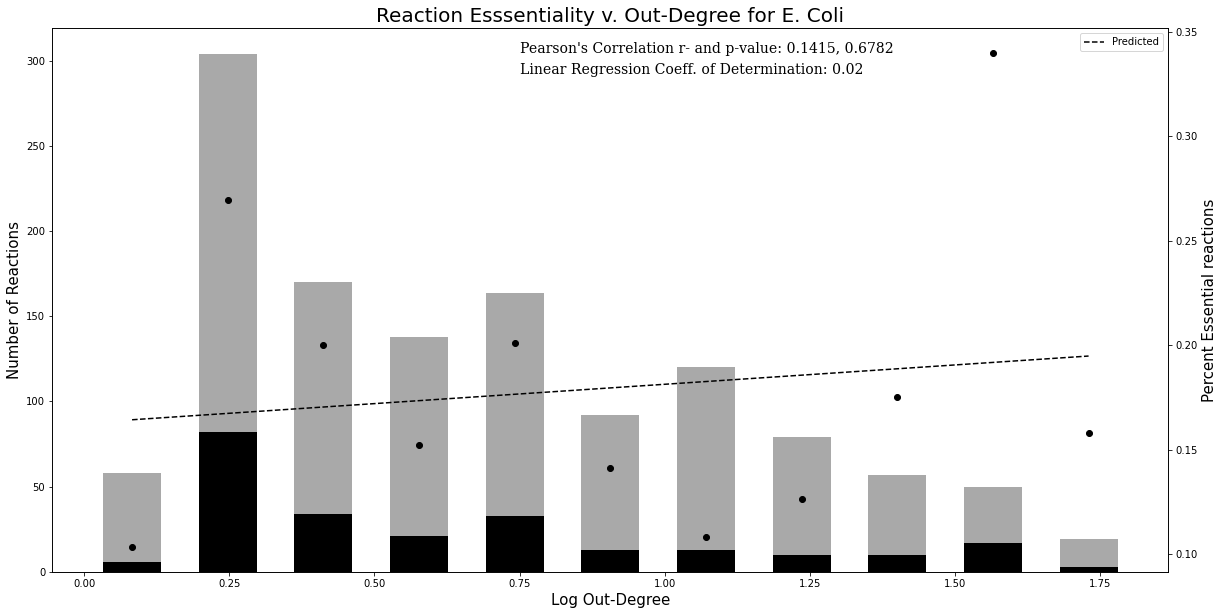

In [179]:
# out-degree analysis

# get all reactants and products- not needed for degree
all_reactants_dict, all_products_dict=all_prods_reacts_dict(fba_ecoli_lofo, ecoli_model, rev=False)
all_reactants_ess_dict, all_products_ess_dict, all_reactants_noness_dict, all_products_noness_dict=split_react_prod_dict_by_ess(fba_ecoli_lofo)

# get histogram data
data_df, pushin_p=get_sharing_data(fba_ecoli_lofo, ecoli_dg, all_reactants_dict, all_products_dict, mets_to_ignore, func=np.min, pp_func=np.mean, ignore_mets=False, rev1=True, rev2=True, return_pushin_p=True, ignore_zero_push=False)
data_df, data_df_sources, data_df_sinks, data_df_ess, data_df_noness=sharing_data_processing(data_df, base=10)
data_df["ess_str"]=[str(i) for i in list(data_df["ess"])]
data_df_f, data_df_f_ess, data_df_f_noness=sharing_data_processing_2(data_df, data_df_sources, data_df_sinks, rm_sources=True, rm_sinks=True)

# compute histogram for log_k_out
manual_bins=create_bins(lb, ub, s, mb=0) # typically use data_df_f with 11 bins, data_df also works well
data_df_hist, hist, bin_edges, bin_edge_pairs=assign_bins(data_df, 'log_k_out', 11, manual_bins=manual_bins, remove_outliers=False, q=0.90, z_filter=False, z_t=2, z_col='z_p_push', return_hist=True) # bins='auto'
data_df_ess_frac=compute_fraction_essential_hist(data_df_hist, hist, bin_edges, bin_edge_pairs, compute_ratio=False)

# linear regression; x should be bin centers which were derived from the ground truth values and y should be frac_ess
r_sq=sk_lr(data_df_ess_frac, 'bin_centers', 'frac_ess')
slope, intercept, r_value, p_value, std_err=sp_lr(data_df_ess_frac, 'bin_centers', 'frac_ess')

# fit line
x=data_df_ess_frac['bin_centers']
y=data_df_ess_frac['frac_ess']
a, b = best_fit(x, y)
yfit = [a + b * xi for xi in x]

# plot
# plt.scatter(x, y, label='Observed')  
# plt.plot(x, yfit, color='red', linestyle='--')
# plt.legend()
# plt.show()

pearson_results=pearsonr(x,y)
corr=pearson_results[0]
pval=pearson_results[1]

# other outputs
print("Number of remaining samples:", len(data_df_hist))

# bar plot
fig, ax1 = plt.subplots(figsize=(20, 10))
total=sum(data_df_ess_frac["num_ess"])+sum(data_df_ess_frac["num_noness"])
ax1.bar(data_df_ess_frac["bin_centers"], data_df_ess_frac["num_ess"], color='black', align='center', width=0.1)
ax1.bar(data_df_ess_frac["bin_centers"], data_df_ess_frac["num_noness"],bottom=data_df_ess_frac["num_ess"], color='darkgrey', width=0.1, align='center')
ax1.set_xlabel('Log Out-Degree', fontsize=15)
ax1.set_ylabel('Number of Reactions', color='black', fontsize=15)
ax1.set_title('Reaction Esssentiality v. Out-Degree for E. Coli', fontsize=20)

# scatter plot
ax2 = ax1.twinx()
ax2.scatter(data_df_ess_frac["bin_centers"], data_df_ess_frac["frac_ess"], color='black')
ax2.plot(x, yfit, label='Predicted', color='black', linestyle='--')  
ax2.text(x=0.75, y=0.34, s=f"Pearson's Correlation r- and p-value: {round(corr, 4)}, {round(pval, 4)}", fontdict=font)
ax2.text(x=0.75, y=0.33, s=f"Linear Regression Coeff. of Determination: {round(r_sq, 4)}", fontdict=font)
ax2.set_ylabel('Percent Essential reactions', color='black', fontsize=15)
plt.legend()
plt.savefig("Figures/Reaction_Essentiality_v_Out_Degree_Histogram.png", bbox='tight', transparent=True, dpi=300)

coefficient of determination: 0.7337761241391343
Slope:  -7.904953069823453
Intercept:  2.6418948564751914
r-value:  -0.8566073336944612
p-value:  0.0007588419617393272
standard error:  1.5871565070177467
(-0.8566073336944614, 0.000758841961739322)
Number of remaining samples: 1021


C:\Users\chati\AppData\Local\Temp/ipykernel_11628/4239126510.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("Figures/Reaction_Essentiality_v_Product_Push_Histogram.png", bbox='tight', transparent=True, dpi=300)


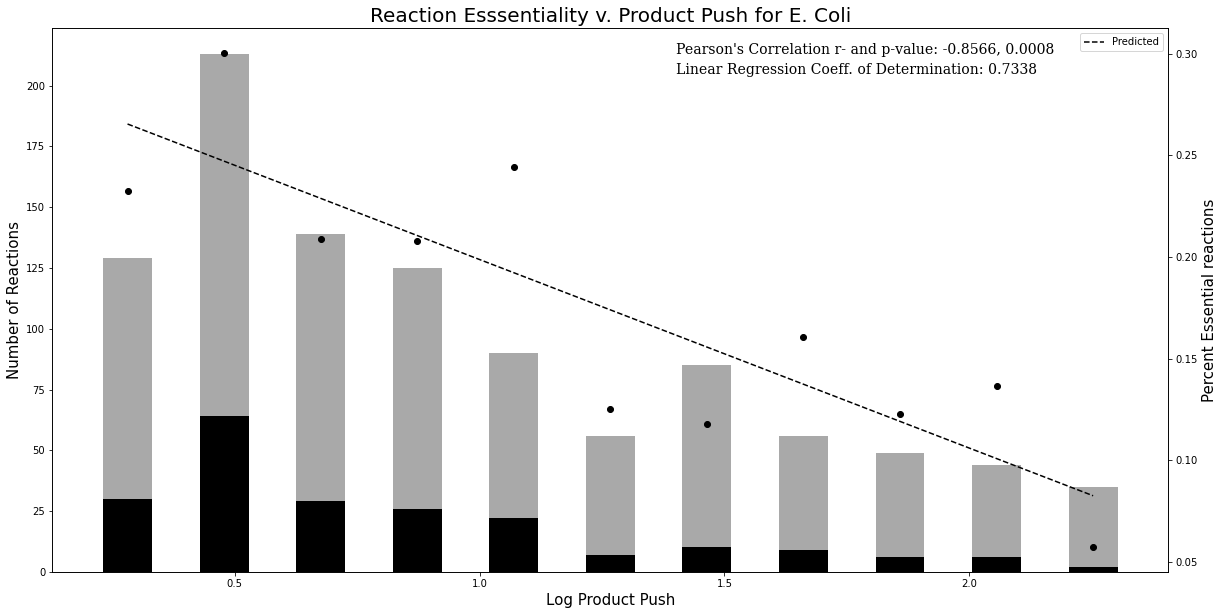

In [180]:
# product push analysis

# get all reactants and products 
all_reactants_dict, all_products_dict=all_prods_reacts_dict(fba_ecoli_lofo, ecoli_model, rev=True)
all_reactants_ess_dict, all_products_ess_dict, all_reactants_noness_dict, all_products_noness_dict=split_react_prod_dict_by_ess(fba_ecoli_lofo)

# get histogram data 
data_df, pushin_p=get_sharing_data(fba_ecoli_lofo, ecoli_dg, all_reactants_dict, all_products_dict, mets_to_ignore, func=np.min, pp_func=np.mean, ignore_mets=False, rev1=True, rev2=True, return_pushin_p=True, ignore_zero_push=False)
data_df, data_df_sources, data_df_sinks, data_df_ess, data_df_noness=sharing_data_processing(data_df)
data_df["ess_str"]=["Essential" if i==1 else "Non-essential" for i in list(data_df["ess"])]
data_df_f, data_df_f_ess, data_df_f_noness=sharing_data_processing_2(data_df, data_df_sources, data_df_sinks, rm_sources=True, rm_sinks=True)

# compute histogram for log_p_push 
manual_bins=create_bins(lb, ub, s, mb=0)
data_df_hist, hist, bin_edges, bin_edge_pairs=assign_bins(data_df_f, 'log_p_push', 11, manual_bins=manual_bins, remove_outliers=False, q=0.90, z_filter=True, z_t=2, z_col='z_p_push', return_hist=True) # bins='auto'
data_df_ess_frac=compute_fraction_essential_hist(data_df_hist, hist, bin_edges, bin_edge_pairs, compute_ratio=False)

# linear regression; x should be bin centers which were derived from the ground truth values and y should be frac_ess; note, it isn't going to fit well, so fit a parabola
r_sq=sk_lr(data_df_ess_frac, 'bin_centers', 'frac_ess')
slope, intercept, r_value, p_value, std_err=sp_lr(data_df_ess_frac, 'bin_centers', 'frac_ess')

# scatter plot
# sns.scatterplot(data_df_ess_frac['bin_centers'], data_df_ess_frac['frac_ess'])

# fit complex functions
import scipy.optimize
def parabola(x, a, b, c):
    return a*x**2 + b*x + c

# fit parabola
x=data_df_ess_frac['bin_centers']
y=data_df_ess_frac['frac_ess']
a, b = best_fit(x, y)
yfit = [a + b * xi for xi in x]

# fit_params, pcov = scipy.optimize.curve_fit(parabola, x, y)
# x_pred=np.arange(0.01, max(x)+0.1, 0.01)
# x_pred=np.arange(min(x), max(x), 0.01)
# y_pred=parabola(x_pred, fit_params[0], fit_params[1], fit_params[2])

# plot
# plt.scatter(x, y, label='Observed')  
print(pearsonr(x,y))
pearson_results=pearsonr(x,y)
corr=pearson_results[0]
pval=pearson_results[1]
# plt.plot(x_pred, y_pred, label='Predicted', color='red')
# plt.plot(x, yfit, color='red', linestyle='--')
# plt.legend()
# plt.show()

# other outputs
print("Number of remaining samples:", len(data_df_hist))

# bar plot
fig, ax1 = plt.subplots(figsize=(20, 10))
total=sum(data_df_ess_frac["num_ess"])+sum(data_df_ess_frac["num_noness"])
ax1.bar(data_df_ess_frac["bin_centers"], data_df_ess_frac["num_ess"], color='black', align='center', width=0.1)
ax1.bar(data_df_ess_frac["bin_centers"], data_df_ess_frac["num_noness"],bottom=data_df_ess_frac["num_ess"], color='darkgrey', width=0.1, align='center')
ax1.set_xlabel('Log Product Push', fontsize=15)
ax1.set_ylabel('Number of Reactions', color='black', fontsize=15)
ax1.set_title('Reaction Esssentiality v. Product Push for E. Coli', fontsize=20)

# scatter plot
ax2 = ax1.twinx()
ax2.scatter(data_df_ess_frac["bin_centers"], data_df_ess_frac["frac_ess"], color='black')
# ax2.plot(x_pred, y_pred, label='Predicted', color='red', linestyle='--') 
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 14}
ax2.plot(x, yfit, label='Predicted', color='black', linestyle='--')  
ax2.set_ylabel('Percent Essential reactions', color='black', fontsize=15)
plt.legend()
# plt.text(2, 200, f"Pearson's Correlation r- and p-value: {corr}, {pval}", fontdict=font)
ax2.text(x=1.4, y=0.3, s=f"Pearson's Correlation r- and p-value: {round(corr, 4)}, {round(pval, 4)}", fontdict=font)
ax2.text(x=1.4, y=0.29, s=f"Linear Regression Coeff. of Determination: {round(r_sq, 4)}", fontdict=font)
plt.savefig("Figures/Reaction_Essentiality_v_Product_Push_Histogram.png", bbox='tight', transparent=True, dpi=300)
# plt.show()

# p push says that essential reactions should be moving more product to other reactions, but does not account for product sharing. We are just saying that these nodes are highly correlated with fraction 
# of essentiality and how much product it pushes. The amount that product is shared across reactions could mean something different. 

C:\Users\chati\AppData\Local\Temp/ipykernel_11628/2745948600.py:49: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("Figures/Reaction_Essentiality_v_Product_Push_and_Sharing_Histogram.png", bbox='tight', transparent=True, dpi=300)


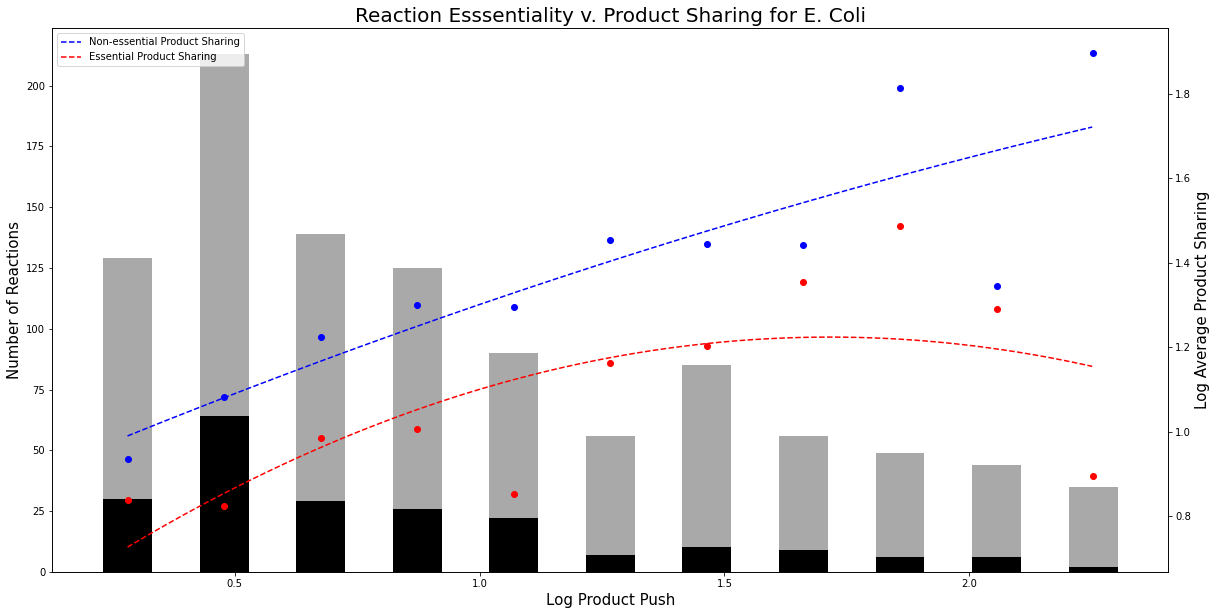

In [181]:
# plot number of essential and average mppush fro both ess and noness
mean_col="log_p"
func=np.mean
ess_mean=[]
noness_mean=[]
for hl in list(data_df_ess_frac["hist_label"]):
    data_df_hist_hl=data_df_hist[data_df_hist["hist_label"]==hl]
    data_df_hist_hl_ess=data_df_hist_hl[data_df_hist_hl["ess"]==1]
    data_df_hist_hl_noness=data_df_hist_hl[data_df_hist_hl["ess"]==0]
    
    # get means
    ess_mean.append(func(data_df_hist_hl_ess[mean_col]))
    noness_mean.append(func(data_df_hist_hl_noness[mean_col]))
    
data_df_ess_frac[f"{mean_col}_avg_ess"]=ess_mean
data_df_ess_frac[f"{mean_col}_avg_noness"]=noness_mean

# bar plot
fig, ax1 = plt.subplots(figsize=(20, 10))
total=sum(data_df_ess_frac["num_ess"])+sum(data_df_ess_frac["num_noness"])
ax1.bar(data_df_ess_frac["bin_centers"], data_df_ess_frac["num_ess"], color='black', align='center', width=0.1)
ax1.bar(data_df_ess_frac["bin_centers"], data_df_ess_frac["num_noness"],bottom=data_df_ess_frac["num_ess"], color='darkgrey', width=0.1, align='center')
ax1.set_xlabel('Log Product Push', fontsize=15)
ax1.set_ylabel('Number of Reactions', color='black', fontsize=15)
ax1.set_title('Reaction Esssentiality v. Product Sharing for E. Coli', fontsize=20)

ax2 = ax1.twinx()

# non essential
x=data_df_ess_frac["bin_centers"]
y=data_df_ess_frac[f'{mean_col}_avg_noness']
ax2.scatter(x, y, color='blue')
fit_params, pcov = scipy.optimize.curve_fit(parabola, x, y)
x_pred=np.arange(min(x), max(x), 0.01)
y_pred=parabola(x_pred, fit_params[0], fit_params[1], fit_params[2])
plt.plot(x_pred, y_pred, label='Non-essential Product Sharing', color='blue', linestyle="--")

# essential
y=data_df_ess_frac[f'{mean_col}_avg_ess']
ax2.scatter(x, y, color='red')
fit_params, pcov = scipy.optimize.curve_fit(parabola, x, y)
x_pred=np.arange(min(x), max(x), 0.01)
y_pred=parabola(x_pred, fit_params[0], fit_params[1], fit_params[2])
plt.plot(x_pred, y_pred, label='Essential Product Sharing', color='red', linestyle="--")

# label
ax2.set_ylabel('Log Average Product Sharing', color='black', fontsize=15)
plt.legend()
plt.savefig("Figures/Reaction_Essentiality_v_Product_Push_and_Sharing_Histogram.png", bbox='tight', transparent=True, dpi=300)

# plt.scatter(data_df_ess_frac['bin_centers'], data_df_ess_frac[f'{mean_col}_avg_ess'], color='red')
# plt.scatter(data_df_ess_frac['bin_centers'], data_df_ess_frac[f'{mean_col}_avg_noness'], color='blue')

coefficient of determination: 0.7430651728413044
coefficient of determination: 0.3786744633698158


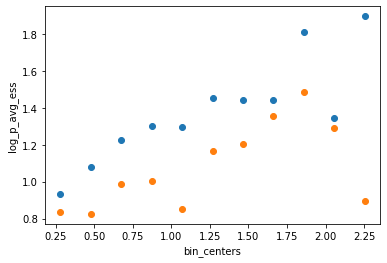

In [184]:
# plot only scatterplots
plot_histogram(data_df_hist, data_df_ess_frac, 'bin_centers', f'{mean_col}_avg_noness', subset=group_ranges(0, 11), frac_ess=True)
plot_histogram(data_df_hist, data_df_ess_frac, 'bin_centers', f'{mean_col}_avg_ess', subset=group_ranges(0, 11), frac_ess=True)

C:\Users\chati\AppData\Local\Temp/ipykernel_11628/2876584272.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("Figures/Product_Sharing_Distributions.png", bbox='tight', transparent=True, dpi=300)


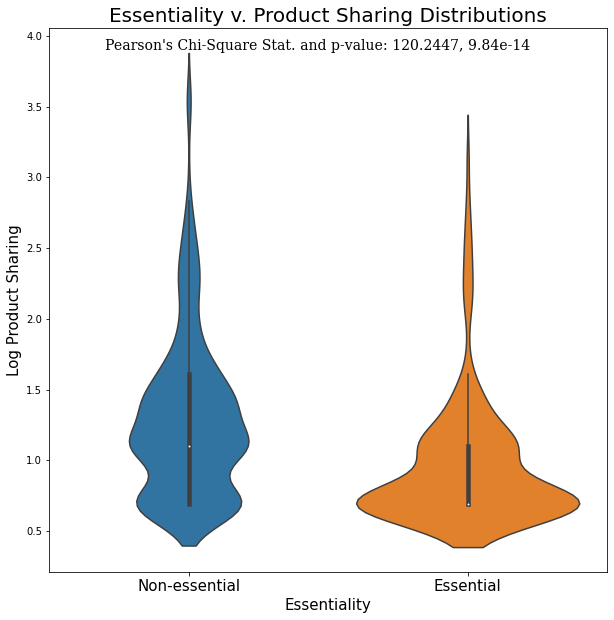

In [185]:
# plot distributional data
fig, ax1 = plt.subplots(figsize=(10, 10))
sns.violinplot(data=data_df_hist, x="ess_str", y="log_p", ax=ax1)
plt.xticks([0,1], ['Non-essential', 'Essential'], fontsize=15)
ax1.set_xlabel('Essentiality', color='black', fontsize=15)
ax1.set_ylabel('Log Product Sharing', color='black', fontsize=15)
ax1.set_title('Essentiality v. Product Sharing Distributions', color='black', fontsize=20)

tf="p"
df_ess_counts=pd.DataFrame.from_dict(Counter(data_df_ess[tf]), orient='index')
df_ess_counts.columns=["ess"]
df_noness_counts=pd.DataFrame.from_dict(Counter(data_df_noness[tf]), orient='index')
df_noness_counts.columns=["noness"]
df_counts=pd.concat([df_ess_counts, df_noness_counts], axis=1).T
df_counts.fillna(0, inplace=True)
stat, p, dof, expected = chi2_contingency(df_counts)

ax1.text(x=-0.3, y=3.9, s=f"Pearson's Chi-Square Stat. and p-value: {round(stat, 4)}, {round(p, 16)}", fontdict=font)
plt.savefig("Figures/Product_Sharing_Distributions.png", bbox='tight', transparent=True, dpi=300)

C:\Users\chati\AppData\Local\Temp/ipykernel_11628/2739144090.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("Figures/Product_Push_Distributions.png", bbox='tight', transparent=True, dpi=300)


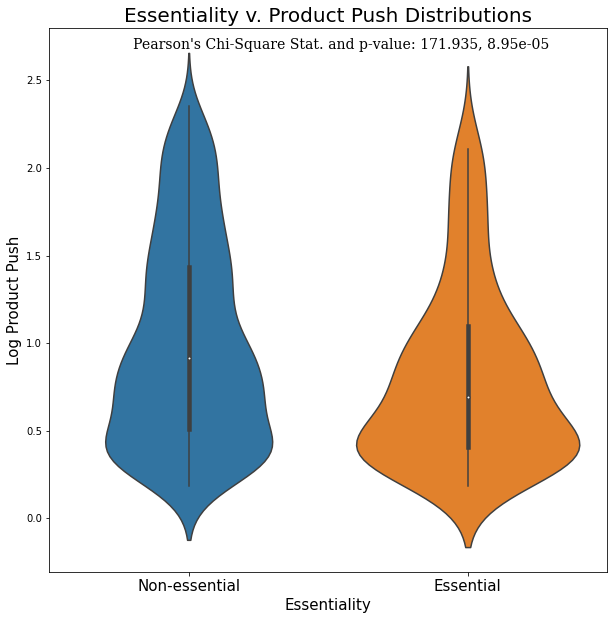

In [186]:
# plot distributional data
fig, ax1 = plt.subplots(figsize=(10, 10))
sns.violinplot(data=data_df_hist, x="ess_str", y="log_p_push", ax=ax1)
plt.xticks([0,1], ['Non-essential', 'Essential'], fontsize=15)
ax1.set_xlabel('Essentiality', color='black', fontsize=15)
ax1.set_ylabel('Log Product Push', color='black', fontsize=15)
ax1.set_title('Essentiality v. Product Push Distributions', color='black', fontsize=20)

tf="p_push"
df_ess_counts=pd.DataFrame.from_dict(Counter(data_df_ess[tf]), orient='index')
df_ess_counts.columns=["ess"]
df_noness_counts=pd.DataFrame.from_dict(Counter(data_df_noness[tf]), orient='index')
df_noness_counts.columns=["noness"]
df_counts=pd.concat([df_ess_counts, df_noness_counts], axis=1).T
df_counts.fillna(0, inplace=True)
stat, p, dof, expected = chi2_contingency(df_counts)

ax1.text(x=-0.2, y=2.68, s=f"Pearson's Chi-Square Stat. and p-value: {round(stat, 4)}, {round(p, 7)}", fontdict=font)
plt.savefig("Figures/Product_Push_Distributions.png", bbox='tight', transparent=True, dpi=300)